# Analisis De Volumen

1. De que tratan las empresas que se estan consitituyendo? NLP en descripcion de actividades.
2. Hay algun patron geografico? (x ej con https://kepler.gl/)
3. Hay cambios a lo largo del tiempo? Algún peak interesante?
4. Qué características de empresa tienden a pedir cuenta corriente y cuáles no?
5. Cuánto tiempo pasa entre que una empresa se constituye y solicitan una cuenta corriente?
6. Podemos ver alguna red de RUTs? Gente que esta relacionada en varias empresas (quizas con https://www.graphext.com/)


In [1]:
#!pip install awswrangler
#!pip install --upgrade seaborn
#!pip install wordcloud
#!pip install --upgrade pandas
#!pip install unidecode
#!pip install gensim

In [2]:
import boto3

session = boto3.session.Session(profile_name='legalbot')
s3 = session.resource('s3')

In [92]:
import pandas as pd
import awswrangler as wr
import seaborn as sns
sns.set_theme()

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,8
rcParams['font.family'] = "roboto"

In [4]:
bucket='legalres-storage-study-json'
prefix = 'processed'
data_location = 's3://{}/{}/'.format(bucket, prefix)

In [5]:
df = wr.s3.read_parquet(path=data_location,
                        boto3_session=session)

In [6]:
df.shape

(798060, 7)

In [7]:
df.columns

Index(['rut', 'cve', 'fecha', 'lugar', 'tipo_sociedad', 'objeto', 'firmas'], dtype='object')

In [8]:
df.head()

,rut,cve,fecha,lugar,tipo_sociedad,objeto,firmas
0,76304233-2,AC1DrSkE1pdl,2013-10-08,"En TEMUCO, Región de LA ARAUCANIA, Chile, a 08...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
1,76304089-5,AC1Dv0J0V4Zr,2013-10-07,"En CONCEPCION, Región del BIOBIO, Chile, a 07 ...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
2,76313238-2,AC1G6RzRn16K,2013-10-24,"En MOLINA, Región del MAULE, Chile, a 24 de oc...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
3,76313389-3,AC1G8rKdG7Xu,2013-10-24,"En COPIAPO, Región de ATACAMA, Chile, a 24 de ...",SOCIEDAD DE RESPONSABILIDAD LIMITADA,La Sociedad tendrá por objeto desarrollar las ...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
4,76313805-4,AC1H6Pt61S4o,2013-10-29,"En TALCA, Región del MAULE, Chile, a 29 de oct...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."


## EDA

### Rut repetidos? 

In [52]:
df['rut'].value_counts().head()

76826175-K    2
77117628-3    2
76304404-1    2
76583346-9    2
76304625-7    1
Name: rut, dtype: Int64

Un ejemplo de rut repetido

In [56]:
df.loc[df['rut'] == df['rut'].value_counts().index[0]]

,rut,cve,fecha,lugar,tipo_sociedad,objeto,firmas
305324,76826175-K,ACl13tlQfihA,2018-01-23,"En MAIPU, Región METROPOLITANA DE SANTIAGO, Ch...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."
315424,76826175-K,AClxnAxUWhTS,2018-10-19,"En MAIPU, Región METROPOLITANA DE SANTIAGO, Ch...",EMPRESA INDIVIDUAL DE RESPONSABILIDAD LIMITADA,La Empresa tendrá por objeto desarrollar las s...,"[{'anotacion': None, 'firmado': 'Firmado elect..."


### Volumen y fechas

In [119]:
volumen = df.groupby(pd.Grouper(key='fecha', freq='m'))['rut'].count().to_frame()

In [120]:
print(volumen.index[0])
print(volumen.index[-1])

2013-05-31 00:00:00
2021-11-30 00:00:00


In [121]:
# remove last month with incomplete data
volumen = volumen.loc[volumen.index[0:-1], :]

In [122]:
# Create linear regression line
nums = range(len(volumen.index))
volumen['nums'] = nums
X = volumen['nums'].values
y = volumen['rut'].values
m, b = np.polyfit(X, y, 1)
preds = [m*x+b for x in nums]
volumen['regresion'] = preds

del volumen['nums']

In [123]:
sns.set_context('poster')

[Text(0.5, 1.0, 'CONSTITUCIONES Mensuales en RES creciendo\nMayo 2013 a Octubre 2021')]

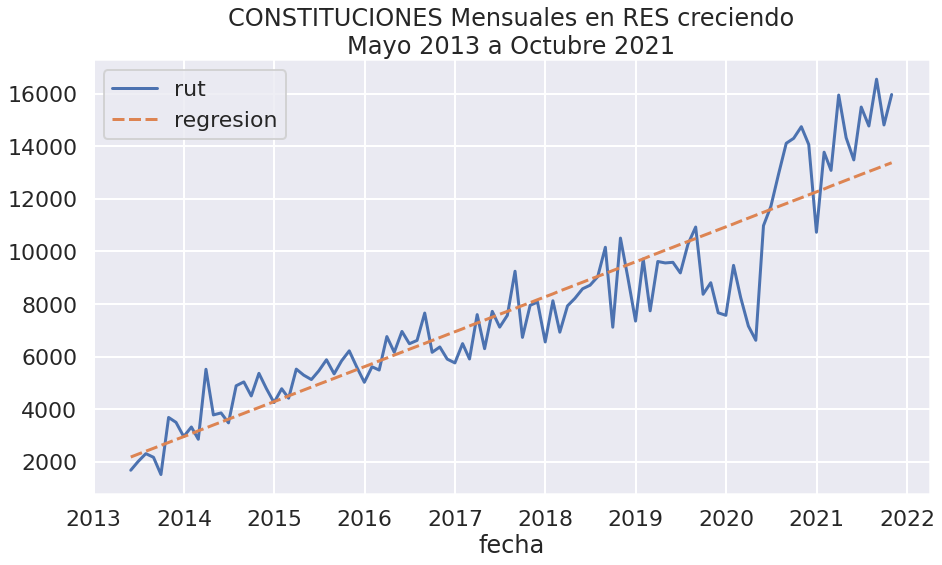

In [124]:
plot = sns.lineplot(data=volumen)
plot.set(title='CONSTITUCIONES Mensuales en RES creciendo\n'
         'Mayo 2013 a Octubre 2021')